# Ethereum Blockchain Analysis with Ethereum-ETL and Bacalhau

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bacalhau-project/examples/blob/main/data-engineering/blockchain-etl/index.ipynb)
[![Open In Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/bacalhau-project/examples/HEAD?labpath=data-engineering/blockchain-etl/index.ipynb)

# Introduction

Mature blockchains are difficult to analyze because of their size. Ethereum-ETL is a tool that makes it easy to extract information from an Ethereum node, but it's not easy to get working in a batch manner. It takes approximately 1 week for an ethereum node to download the entire chain and importing and exporting data from the ethereum node is slow.

For this example we ran an ethereum node for a week and allowed it to synchronise. We then ran ethereum-etl to extract the information and pinned it on Filecoin. This means that we can both now access the data without having to run another ethereum node.

### Prerequisites

* Python 3 
* The Bacalhau client - [Installation instructions](https://docs.bacalhau.org/getting-started/installation)

In [ ]:
!command -v bacalhau >/dev/null 2>&1 || (export BACALHAU_INSTALL_DIR=.; curl -sL https://get.bacalhau.org/install.sh | bash)
path=!echo $PATH
%env PATH=./:{path[0]}

env: PATH=./:/Users/phil/.pyenv/versions/3.9.7/bin:/opt/homebrew/Caskroom/google-cloud-sdk/latest/google-cloud-sdk/bin:/Users/phil/.gvm/bin:/opt/homebrew/opt/findutils/libexec/gnubin:/opt/homebrew/opt/coreutils/libexec/gnubin:/opt/homebrew/Caskroom/google-cloud-sdk/latest/google-cloud-sdk/bin:/Users/phil/.pyenv/shims:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/usr/local/MacGPG2/bin:/Users/phil/.nexustools


## 1. Analysing Ethereum Data Locally

First let's download one of the IPFS files and inspect it locally. You can see the full list of IPFS CIDs in the appendix.

In [59]:
%%bash
wget -q -O file.tar.gz https://w3s.link/ipfs/bafybeihvmcrs5voz2pzpdkb3b7kt4bbb6kpi5ohspgrrs7bqkalpwmfdpq
tar -xvf file.tar.gz

x output_1100000/
x output_1100000/token_transfers/
x output_1100000/token_transfers/start_block=01100000/
x output_1100000/token_transfers/start_block=01100000/end_block=01199999/
x output_1100000/token_transfers/start_block=01100000/end_block=01199999/token_transfers_01100000_01199999.csv
x output_1100000/contracts/
x output_1100000/contracts/start_block=01100000/
x output_1100000/contracts/start_block=01100000/end_block=01199999/
x output_1100000/contracts/start_block=01100000/end_block=01199999/contracts_01100000_01199999.csv
x output_1100000/transactions/
x output_1100000/transactions/start_block=01100000/
x output_1100000/transactions/start_block=01100000/end_block=01199999/
x output_1100000/transactions/start_block=01100000/end_block=01199999/transactions_01100000_01199999.csv
x output_1100000/receipts/
x output_1100000/receipts/start_block=01100000/
x output_1100000/receipts/start_block=01100000/end_block=01199999/
x output_1100000/receipts/start_block=01100000/end_block=011999

In [17]:
%%bash
pip install pandas


[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [69]:
# Use pandas to read in transation data and clean up the columns
import pandas as pd
df = pd.read_csv('output_1100000/transactions/start_block=01100000/end_block=01199999/transactions_01100000_01199999.csv')
df['value'] = df['value'].astype('float')
df['from_address'] = df['from_address'].astype('string')
df['to_address'] = df['to_address'].astype('string')
df['hash'] = df['hash'].astype('string')
df['block_hash'] = df['block_hash'].astype('string')
df['block_datetime'] = pd.to_datetime(df['block_timestamp'], unit='s')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520716 entries, 0 to 520715
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   hash                      520716 non-null  string        
 1   nonce                     520716 non-null  int64         
 2   block_hash                520716 non-null  string        
 3   block_number              520716 non-null  int64         
 4   transaction_index         520716 non-null  int64         
 5   from_address              520716 non-null  string        
 6   to_address                518546 non-null  string        
 7   value                     520716 non-null  float64       
 8   gas                       520716 non-null  int64         
 9   gas_price                 520716 non-null  int64         
 10  input                     520716 non-null  object        
 11  block_timestamp           520716 non-null  int64         
 12  ma

The following code inspects the daily trading volume of Ethereum for a single chunk (100,000 blocks) of data.

This is all good, but we can do better. We can use the Bacalhau client to download the data from IPFS and then run the analysis on the data in the cloud. This means that we can analyse the entire Ethereum blockchain without having to download it locally.

<AxesSubplot:xlabel='block_datetime'>

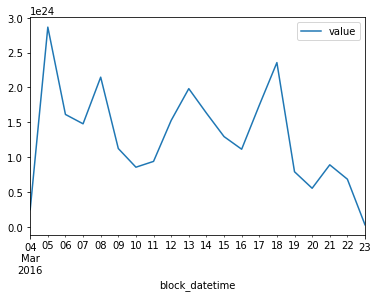

In [70]:
# Total volume per day
df[['block_datetime', 'value']].groupby(pd.Grouper(key='block_datetime', freq='1D')).sum().plot()





## 2. Analysing Ethereum Data With Bacalhau

To run jobs on the Bacalhau network you need to package your code. In this example I will package the code as a Docker image.

But before we do that, we need to develop the code that will perform the analysis. The code below is a simple script to parse the incoming data and produce a CSV file with the daily trading volume of Ethereum.

In [155]:
%%writefile main.py
import glob, os, sys, shutil, tempfile
import pandas as pd

def main(input_dir, output_dir):
    search_path = os.path.join(input_dir, "output*", "transactions", "start_block*", "end_block*", "transactions_*.csv")
    csv_files = glob.glob(search_path)
    if len(csv_files) == 0:
        print("No CSV files found in %s" % search_path)
        sys.exit(1)
    for transactions_file in csv_files:
        print("Loading %s" % transactions_file)
        df = pd.read_csv(transactions_file)
        df['value'] = df['value'].astype('float')
        df['block_datetime'] = pd.to_datetime(df['block_timestamp'], unit='s')
        
        print("Processing %d blocks" % (df.shape[0]))
        results = df[['block_datetime', 'value']].groupby(pd.Grouper(key='block_datetime', freq='1D')).sum()
        print("Finished processing %d days worth of records" % (results.shape[0]))

        save_path = os.path.join(output_dir, os.path.basename(transactions_file))
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        print("Saving to %s" % (save_path))
        results.to_csv(save_path)

def extractData(input_dir, output_dir):
    search_path = os.path.join(input_dir, "*.tar.gz")
    gz_files = glob.glob(search_path)
    if len(gz_files) == 0:
        print("No tar.z files found in %s" % search_path)
        sys.exit(1)
    for f in gz_files:
        shutil.unpack_archive(filename=f, extract_dir=output_dir)

if __name__ == "__main__":
    if len(sys.argv) != 3:
        print('Must pass arguments. Format: [command] input_dir output_dir')
        sys.exit()
    with tempfile.TemporaryDirectory() as tmp_dir:
        extractData(sys.argv[1], tmp_dir)
        main(tmp_dir, sys.argv[2])

Overwriting main.py


Next, let's make sure the file works as expected...

In [156]:
%%bash
python main.py . outputs/

Loading /var/folders/kr/pl4p96k11b55hp5_p9l_t8kr0000gn/T/tmpv1gvkg2v/output_1100000/transactions/start_block=01100000/end_block=01199999/transactions_01100000_01199999.csv
Processing 520716 blocks
Finished processing 20 days worth of records
Saving to outputs/transactions_01100000_01199999.csv


And finally, package the code inside a Docker image to make the process reproducible. Here I'm passing the Bacalhau default `/inputs` and `/outputs` directories. The `/inputs` directory is where the data will be read from and the `/outputs` directory is where the results will be saved to.

In [157]:
%%writefile Dockerfile
FROM python:3.11-slim-bullseye
WORKDIR /src
RUN pip install pandas==1.5.1
ADD main.py .
CMD ["python", "main.py", "/inputs", "/outputs"]

Overwriting Dockerfile


We've already pushed the container, but for posterity, the following command pushes this container to GHCR.

```bash
docker buildx build --platform linux/amd64 --push -t ghcr.io/bacalhau-project/examples/blockchain-etl:0.0.1 .
```


### Analysing Ethereum Data On Bacalhau

[Bacalhau](https://www.bacalhau.org/) is a distributed computing platform that allows you to run jobs on a network of computers. It is designed to be easy to use and to run on a variety of hardware. In this example, we will use it to run our analysis on the Ethereum blockchain.

To submit a job, you can use the Bacalhau CLI. The following command will run the container above on the IPFS data -- the long hash -- shown at the start of this notebook. Let's confirm that the results are as expected.


In [158]:
%%bash --out job_id
bacalhau docker run \
    --id-only \
    --input-volumes bafybeihvmcrs5voz2pzpdkb3b7kt4bbb6kpi5ohspgrrs7bqkalpwmfdpq:/inputs/data.tar.gz \
    ghcr.io/bacalhau-project/examples/blockchain-etl:0.0.6

In [159]:
%env JOB_ID={job_id}

env: JOB_ID=15673ac4-848f-4c7f-81a0-7e018fe9ba78



Running the commands will output a UUID that represents the job that was created. You can check the status of the job with the following command:


In [160]:
%%bash
bacalhau list --id-filter ${JOB_ID}

 CREATED   ID        JOB                      STATE      VERIFIED  PUBLISHED               
 11:48:46  15673ac4  Docker ghcr.io/bacal...  Completed            /ipfs/QmP5z2CPPybiVf... 



Wait until it says `Completed` and then get the results.

To find out more information about your job, run the following command:

In [161]:
%%bash
bacalhau describe ${JOB_ID}

APIVersion: V1beta1
ClientID: 77cf46c04f88ffb1c3e0e4b6e443724e8d2d87074d088ef1a6294a448fa85d2e
CreatedAt: "2022-11-18T11:48:46.303661585Z"
Deal:
  Concurrency: 1
ExecutionPlan:
  ShardsTotal: 1
ID: 15673ac4-848f-4c7f-81a0-7e018fe9ba78
JobState:
  Nodes:
    QmVAb7r2pKWCuyLpYWoZr9syhhFnTWeFaByHdb8PkkhLQG:
      Shards:
        "0":
          NodeId: QmVAb7r2pKWCuyLpYWoZr9syhhFnTWeFaByHdb8PkkhLQG
          PublishedResults:
            CID: QmP5z2CPPybiVfGxyfEBjVqGF4S8VRFx59ucKShLDsBLWk
            Name: job-15673ac4-848f-4c7f-81a0-7e018fe9ba78-shard-0-host-QmVAb7r2pKWCuyLpYWoZr9syhhFnTWeFaByHdb8PkkhLQG
            StorageSource: IPFS
          RunOutput:
            exitCode: 0
            runnerError: ""
            stderr: ""
            stderrtruncated: false
            stdout: |
              Loading /tmp/tmpyw253u9x/output_1100000/transactions/start_block=01100000/end_block=01199999/transactions_01100000_01199999.csv
              Processing 520716 blocks
              Finished pr

And let's inspect the results.

In [162]:
%%bash
mkdir -p ./results # Temporary directory to store the results
bacalhau get --output-dir ./results ${JOB_ID} # Download the results

Fetching results of job '15673ac4-848f-4c7f-81a0-7e018fe9ba78'...
Results for job '15673ac4-848f-4c7f-81a0-7e018fe9ba78' have been written to...
./results


The docker run command above used the `outputs` volume as a results folder so when we download them they will be stored in a  folder within `volumes/outputs`.

In [166]:
%%bash
ls -lah results/combined_results/outputs

total 4.0K
drwxr-xr-x 3 phil staff  96 Nov 18 11:49 .
drwxr-xr-x 5 phil staff 160 Nov 18 11:49 ..
-rw-r--r-- 3 phil staff 692 Nov 18 11:49 transactions_01100000_01199999.csv


<AxesSubplot:xlabel='block_datetime'>

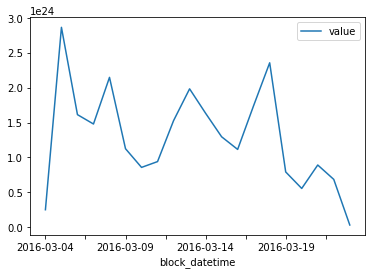

In [169]:
import pandas as pd

df = pd.read_csv('results/combined_results/outputs/transactions_01100000_01199999.csv', index_col='block_datetime')
df.plot()

### Massive Scale Ethereum Analysis

Ok so that works. Let's scale this up! We can run the same analysis on the entire Ethereum blockchain (up to the point where I have uploaded the Ethereum data). To do this, we need to run the analysis on each of the chunks of data that we have stored on IPFS. We can do this by running the same job on each of the chunks.

In [181]:
%%bash
printf "" > job_ids.txt
for h in $(cat hashes.txt); do \
    bacalhau docker run \
    --id-only \
    --wait=false \
    --input-volumes=$h:/inputs/data.tar.gz \
    ghcr.io/bacalhau-project/examples/blockchain-etl:0.0.6 >> job_ids.txt 
done

In [182]:
%%bash
cat job_ids.txt

da73f5b0-89c5-4f6f-a6e9-ff4ae186e8a4
250285e8-0dec-4d89-b627-ea950420c504
4d7f30ef-e409-43ce-9bba-1a4a6a4d337a
e36516f3-5252-4a63-871b-b624366c7e22
f6e12bac-0bf4-48c3-828d-2c2f62d0f97f
c004d954-32eb-4a90-a5e3-c266678a5607
46459ab2-5430-40c8-bf3c-4b2a799a500c
ccd6fae5-70fb-46ef-a256-d7a484335d79
d63c4e08-fa76-44b8-b94e-681a5b342fe6
19462995-324a-4872-9800-6c0a95fdf0e7
8fa72856-c1da-455b-b56d-d60c6b10b655
3aa1f9bd-ce60-43d5-9b49-ec2f5beb4c6c


In [187]:
%%bash
rm -rf ./combined_results && mkdir -p ./combined_results
for id in $(cat job_ids.txt); do \
    rm -rf results && mkdir results
    bacalhau get --output-dir ./results $id
    cp results/combined_results/outputs/* ./combined_results
done

Fetching results of job 'da73f5b0-89c5-4f6f-a6e9-ff4ae186e8a4'...
Results for job 'da73f5b0-89c5-4f6f-a6e9-ff4ae186e8a4' have been written to...
./results
Fetching results of job '250285e8-0dec-4d89-b627-ea950420c504'...
Results for job '250285e8-0dec-4d89-b627-ea950420c504' have been written to...
./results
Fetching results of job '4d7f30ef-e409-43ce-9bba-1a4a6a4d337a'...
Results for job '4d7f30ef-e409-43ce-9bba-1a4a6a4d337a' have been written to...
./results
Fetching results of job 'e36516f3-5252-4a63-871b-b624366c7e22'...
Results for job 'e36516f3-5252-4a63-871b-b624366c7e22' have been written to...
./results
Fetching results of job 'f6e12bac-0bf4-48c3-828d-2c2f62d0f97f'...
Results for job 'f6e12bac-0bf4-48c3-828d-2c2f62d0f97f' have been written to...
./results
Fetching results of job 'c004d954-32eb-4a90-a5e3-c266678a5607'...
Results for job 'c004d954-32eb-4a90-a5e3-c266678a5607' have been written to...
./results
Fetching results of job '46459ab2-5430-40c8-bf3c-4b2a799a500c'...
Resu

2022/11/18 12:13:42 CleanupManager.fnsMutex violation CRITICAL section took 21.65ms 21650000 (threshold 10ms)
2022/11/18 12:13:46 CleanupManager.fnsMutex violation CRITICAL section took 10.564ms 10564000 (threshold 10ms)
2022/11/18 12:14:03 CleanupManager.fnsMutex violation CRITICAL section took 20.862ms 20862000 (threshold 10ms)
2022/11/18 12:14:07 CleanupManager.fnsMutex violation CRITICAL section took 18.909ms 18909000 (threshold 10ms)
2022/11/18 12:14:19 CleanupManager.fnsMutex violation CRITICAL section took 19.754ms 19754000 (threshold 10ms)
2022/11/18 12:15:26 CleanupManager.fnsMutex violation CRITICAL section took 21.134ms 21134000 (threshold 10ms)


<AxesSubplot:xlabel='block_datetime'>

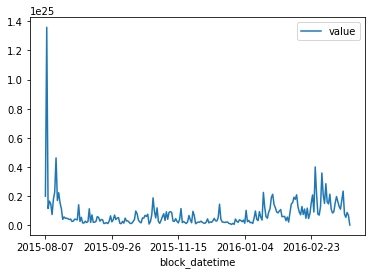

In [212]:
import os, glob
import pandas as pd

# Get CSV files list from a folder
path = os.path.join("combined_results", "*.csv")
csv_files = glob.glob(path)

# Read each CSV file into a list of DataFrames
df_list = (pd.read_csv(file, index_col='block_datetime') for file in csv_files)

# Concatenate all DataFrames
df_unsorted = pd.concat(df_list, ignore_index=False)

# Some files will cross days, so group by day and sum the values
df = df_unsorted.groupby(level=0).sum()

# Plot
df.plot()

That's it! There is several years of Ethereum transaction volume data.

## Appendix 1: List Ethereum Data CIDs 

The following list is a list of IPFS CID's for the Ethereum data that we used in this tutorial. You can use these CID's to download the rest of the chain if you so desire. The CIDs are ordered by block number and they increase 100,000 blocks at a time. Here's a list of ordered CIDs:

In [213]:
%%bash
cat hashes.txt

bafybeihzxaqjpvlb7rzu4ttipma7sths42eolrv7fq6bsdrbb7hckb3oo4
bafybeihsz6omseh27ayglbcebshk6crgbnj2jalt524ihgfqkshcwgmdhq
bafybeicxuum3qerxe5v22fcmyryfmumbxskqdkst56zpaofjsgjff5qrom
bafybeiggm7nhwf5roouchk7lir6vcxoe2luojdlcyukqlqj5q7mibd2i5e
bafybeiflcauohsv4uz3m7e2z5ybcoxn7gvj2rko5pl25xulw22g4qnygpe
bafybeidefyiltnd3gpuhy3sicygnsafnocnzxlcoexxsxeobearat2wzym
bafybeigcyteztp5pdjr3imx55rl2tdg3maigt4w6fpse6dctf2fodusxdm
bafybeiffn7wlhjwajkhhk7cvuxbwuwaodd4h3qfzhhyp33jh3kp6u3usui
bafybeievtkkhkrj2eydcjklp532hvleww4i4gvfblvwvinwnu3646sprqu
bafybeieia52c7t6t35zt2lkcshiwtehsyxojs3hhpvcu367y5em6d7tpna
bafybeicsfa5x4ns46kmvqgauwwskjl6bl3nrkxgo5i33ijj4mjlfh2vvfy
bafybeihvmcrs5voz2pzpdkb3b7kt4bbb6kpi5ohspgrrs7bqkalpwmfdpq

## Appendix 2: Setting up an Ethereum Node

In the course of writing this example I had to setup an Ethereum node. It was a slow and painful process so I thought I would share the steps I took to make it easier for others.

### Geth setup and sync

Geth supports Ubuntu by default, so use that when creating a VM. Use Ubuntu 22.04 LTS.

```bash
gcloud compute instances create phil-ethereum-node \
    --project=bacalhau-development --zone=europe-west2-c \
    --machine-type=c2-standard-4 --tags=geth \
    --create-disk=auto-delete=yes,boot=yes,device-name=phil-ethereum-node,image=projects/ubuntu-os-cloud/global/images/ubuntu-2204-jammy-v20221101a,mode=rw,size=50,type=projects/bacalhau-development/zones/europe-west2-c/diskTypes/pd-balanced \
    --create-disk=auto-delete=yes,device-name=phil-ethereum-disk,mode=rw,name=phil-ethereum-disk,size=3000,type=projects/bacalhau-development/zones/europe-west2-c/diskTypes/pd-standard
```

Mount the disk:

```bash
sudo mkfs.ext4 -m 0 -E lazy_itable_init=0,lazy_journal_init=0,discard /dev/sdb
sudo mkdir -p /mnt/disks/ethereum
sudo mount -o discard,defaults /dev/sdb /mnt/disks/ethereum
sudo chmod a+w /mnt/disks/ethereum
```

```bash
sudo add-apt-repository -y ppa:ethereum/ethereum
sudo apt-get update
sudo apt-get install -y ethereum
sudo mkdir /prysm && cd /prysm
sudo curl https://raw.githubusercontent.com/prysmaticlabs/prysm/master/prysm.sh --output prysm.sh && sudo chmod +x prysm.sh
```

Run as a new user:

```bash
sudo useradd -d /home/ethuser -m --uid 10000 ethuser
sudo chown -R ethuser /prysm
```

```
sudo tee "/etc/systemd/system/geth.service" > /dev/null <<'EOF'
[Unit]
Description=Geth

[Service]
Type=simple
User=ethuser
Restart=always
RestartSec=12
ExecStart=/bin/geth --syncmode "full" --datadir /mnt/disks/ethereum

[Install]
WantedBy=default.target
EOF

sudo tee "/etc/systemd/system/prysm.service" > /dev/null <<'EOF'
[Unit]
Description=Prysm

[Service]
Type=simple
User=ethuser
Restart=always
RestartSec=12
ExecStart=/prysm/prysm.sh beacon-chain --execution-endpoint=/mnt/disks/ethereum/geth.ipc --suggested-fee-recipient=0x7f68cb1cdE000AF82291A0D0c21E0f88FD7dB440 --checkpoint-sync-url=https://beaconstate.info
--genesis-beacon-api-url=https://beaconstate.info --accept-terms-of-use --datadir /mnt/disks/ethereum/prysm

[Install]
WantedBy=default.target
EOF

sudo systemctl daemon-reload
sudo systemctl enable prysm.service
sudo systemctl enable geth.service
sudo systemctl daemon-reload
sudo service prysm start 
sudo service geth start 
```

Check they are running:

```bash
service prysm status
service geth status
```

Watch the logs:

```bash
journalctl -u prysm -f
```

Prysm will need to finish synchronising before geth will start syncronising.

In Prysm you will see lots of log messages saying: `Synced new block`, and in Geth you will see: `Syncing beacon headers    downloaded=11,920,384 left=4,054,753  eta=2m25.903s`. This tells you how long it will take to sync the beacons. Once that's done, get will start synchronising the blocks.

Bring up the ethereum javascript console with:

```
sudo geth --datadir /mnt/disks/ethereum/ attach
```

Once the block sync has started, `eth.syncing` will return values. Before it starts, this value will be `false`.

Note that by default, geth will perform a fast sync, without downloading the full blocks. The `syncmode=flull` flag forces geth to do a full sync. If we didn't do this, then we wouldn't be able to backup the data properly.

### Extracting the Data

```bash
# Install pip and ethereum-etl
sudo apt-get install -y python3-pip
sudo pip3 install ethereum-etl
cd
mkdir ethereum-etl
cd ethereum-etl

# Export data with one 100000-item batch in a directory, up to 2499999 for now
# The full chain is about 15m blocks
for i in $(seq 0 100000 2499999); do sudo ethereumetl export_all --partition-batch-size 100000 --start $i --end $(expr $i + 100000 - 1)  --provider-uri file:///mnt/disks/ethereum/geth.ipc -o output_$i; done
```

### Upload the data

Tar and compress the directories to make them easier to upload:

```bash
sudo apt-get install -y jq # Install jq to parse the cid
cd
cd ethereum-etl
for i in $(seq 0 100000 2499999); do tar cfz output_$i.tar.gz output_$i; done
```

Export your Web3.storage JWT API key as an environment variable called `TOKEN`:

```bash
printf "" > hashes.txt
for i in $(seq 0 100000 2499999); do curl -X POST https://api.web3.storage/upload -H "Authorization: Bearer ${TOKEN}" -H 'accept: application/json' -H 'Content-Type: text/plain' -H "X-NAME: ethereum-etl-block-$i" --data-binary "@output_$i.tar.gz" | jq --raw-output '.cid' >> hashes.txt; done
```
